<a href="https://colab.research.google.com/github/nedokormysh/GB_DA_algorithms/blob/lesson5/DA_algorithms_hw_5_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split

# Задание 1.

Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [9]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000, 
                                                                          n_features=2, n_informative=2, 
                                                                          n_classes=2, n_redundant=0,                                                                      
                                                                          n_clusters_per_class=1, random_state=3,
                                                                          flip_y=0.3
                                                                          )

classification_data.shape

(1000, 2)

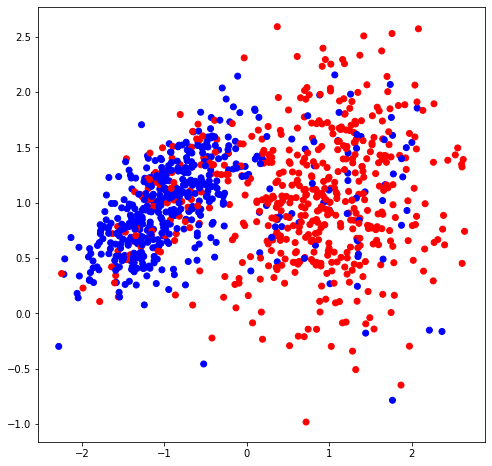

In [10]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [11]:
# Реализуем генерацию N бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [12]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [13]:
# Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [14]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [15]:
# Расчет критерия Джини

def gini(labels):
    labels = list(labels)

    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    gini = 1
    for label in classes:
        p = classes[label] / len(labels)
        gini -= p ** 2
        
    return gini

In [16]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [17]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [18]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] 
    # - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [19]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [20]:
# функция формирования случайного леса

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [21]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [22]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [23]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [24]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [25]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [26]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, train_labels, test_labels, forest, n_trees=1):
    plt.figure(figsize = (14, 7))

    if n_trees > 1: plt.suptitle(f'{n_trees} trees', fontsize=16)
    else: plt.suptitle(f'{n_trees} tree', fontsize=16)

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote( forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy = {accuracy_metric(train_labels, tree_vote(forest, train_data)):.2f}', size=15)

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy = {accuracy_metric(test_labels, tree_vote(forest, test_data)):.2f}', size=15)

In [27]:
tr_ac = []
te_ac = []
number_of_trees = [1, 3, 5, 10, 30, 50, 80, 100]

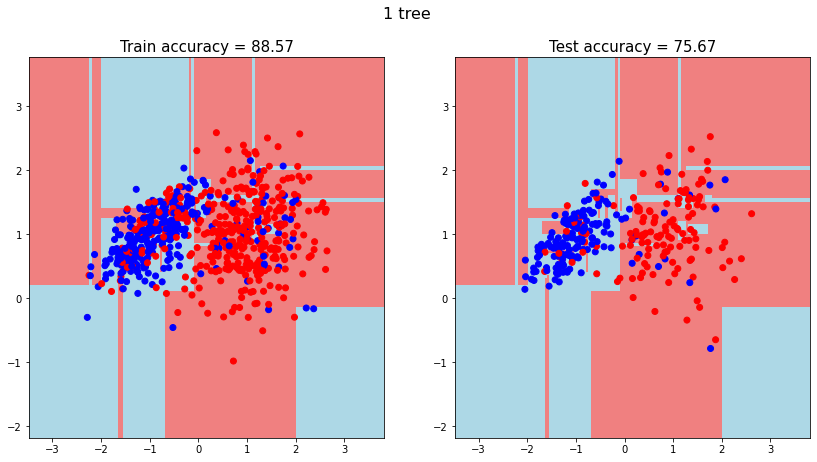

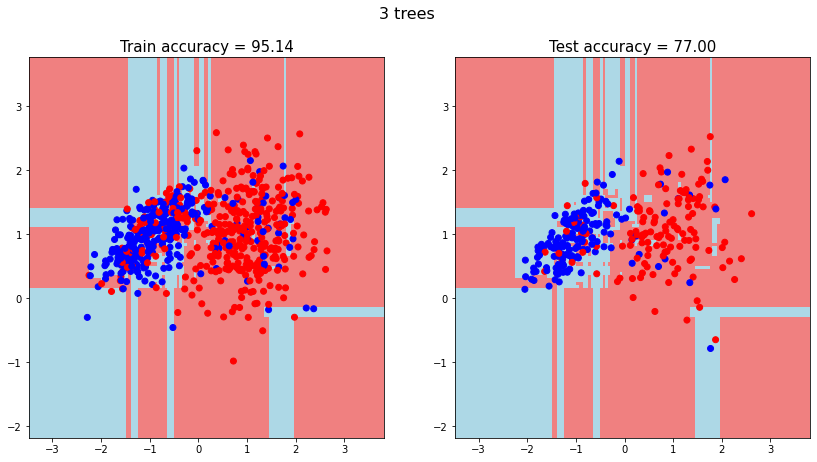

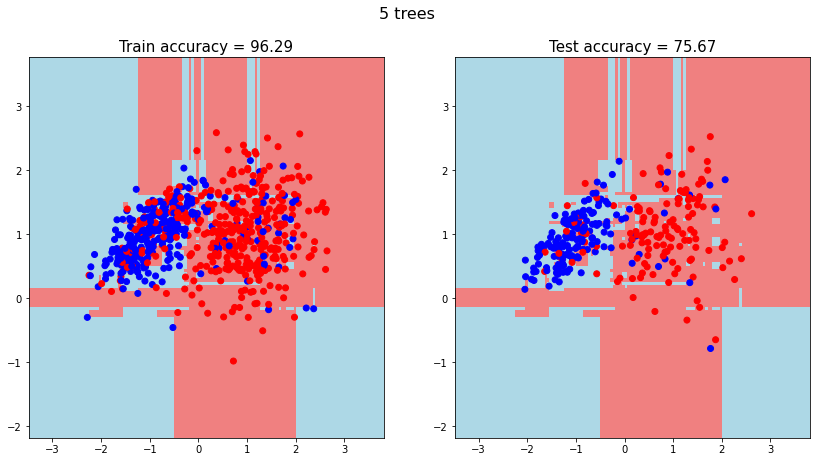

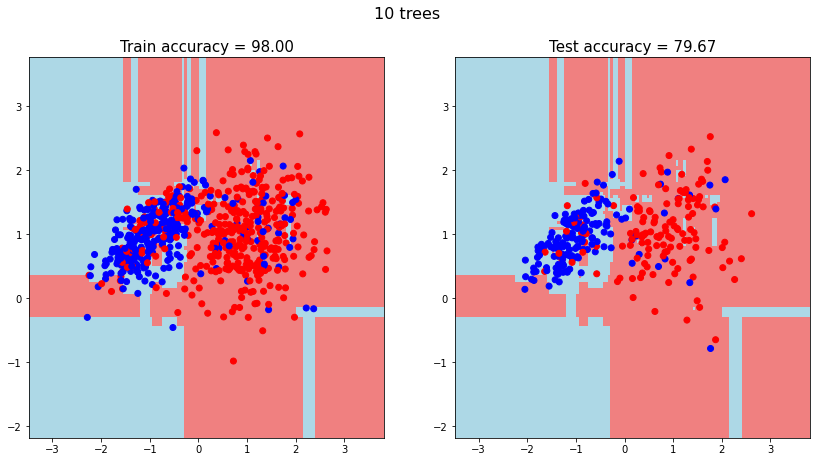

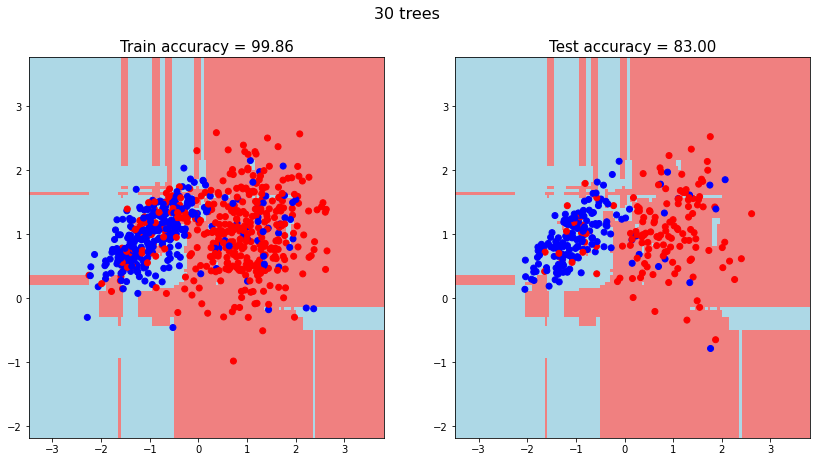

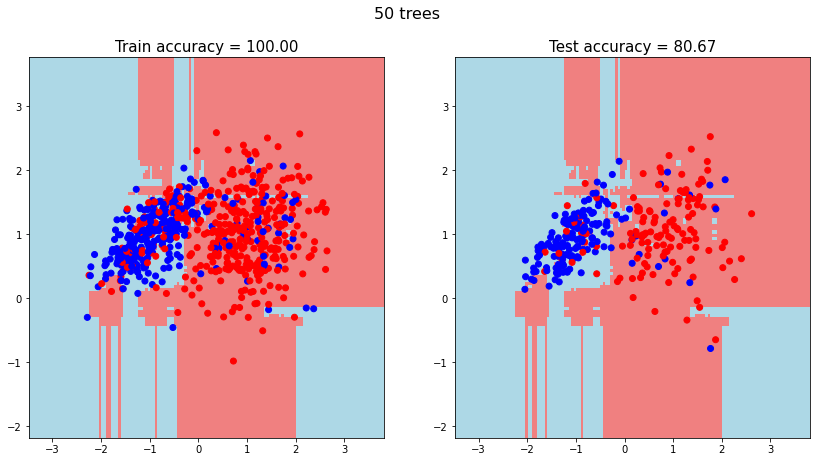

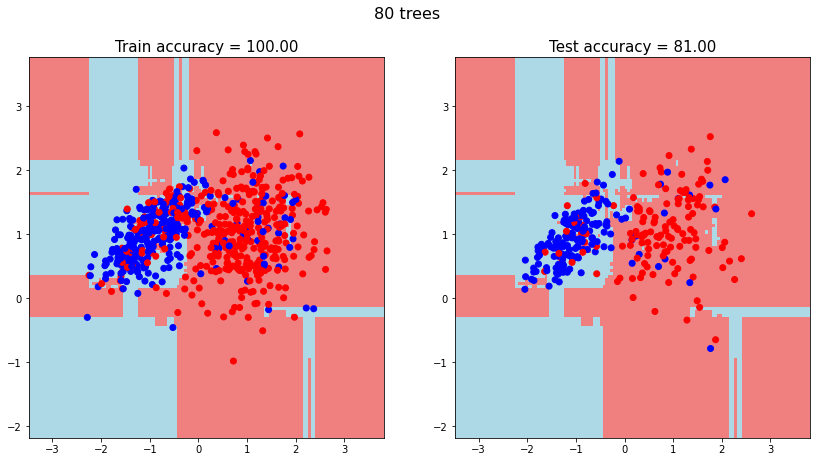

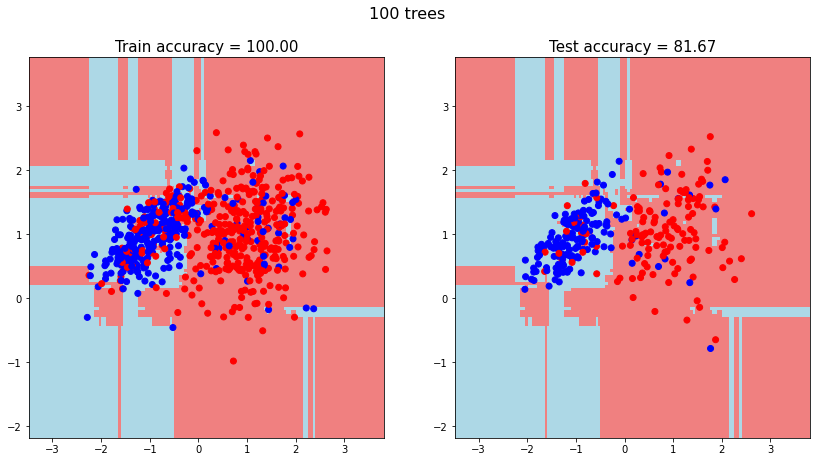

In [28]:
for n_trees in number_of_trees:
  forest = random_forest(train_data, train_labels, n_trees)
  train_answers = tree_vote(forest, train_data)
  test_answers = tree_vote(forest, test_data)

  train_accuracy = accuracy_metric(train_labels, train_answers)
  tr_ac.append(train_accuracy)
  test_accuracy = accuracy_metric(test_labels, test_answers)
  te_ac.append(test_accuracy)

  visualize(train_data, test_data, train_labels, test_labels, forest, n_trees)

Text(0.5, 1.0, 'Зависимость точности от количества деревьев на тренировочной выборке\n')

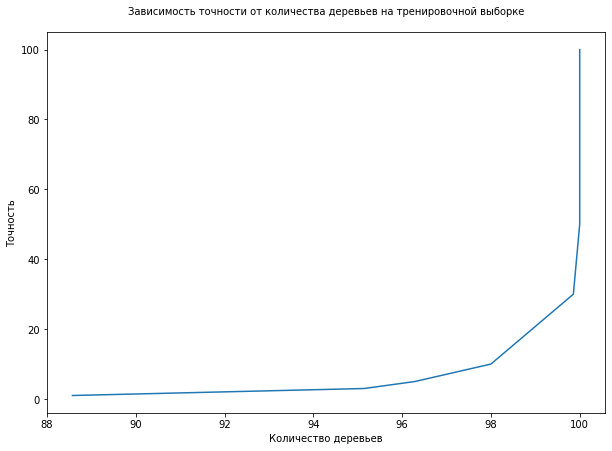

In [29]:
plt.figure(figsize = (10, 7))
plt.plot(tr_ac, number_of_trees)
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности от количества деревьев на тренировочной выборке\n', size=10)

Text(0.5, 1.0, 'Зависимость точности от количества деревьев на тестовой выборке\n')

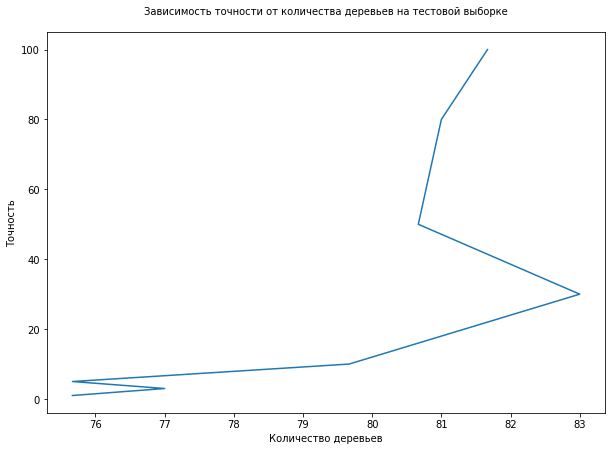

In [30]:
plt.figure(figsize = (10, 7))
plt.plot(te_ac, number_of_trees)
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности от количества деревьев на тестовой выборке\n', size=10)

# Задание 2.

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем



Можем наблюдать, что при увеличении количества деревьев наша точность решения возрастает на тренировочной выборке, но на тестовой части качество решения начинает падать.

Также мы видим выход на плато на обучающей выборке.

Соответвенно, мы имеем переобучение при увеличении количества деревьев.
При малом же количестве дерьев модель может быть недообученной. Таким образом, количество деревьев может быть настраеваемым гиперпараметром.



# Задание 3.

Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [31]:
# Реализуем генерацию N бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.
# также будем формировать список индексов элементов, которые не вошли в массив.
# и создадим лист freq, в котором будем считать сколько раз элемент попал в oob, а не в нашу обучающую часть

random.seed(42)

def get_bootstrap(data, labels, N):
    
    n_samples = data.shape[0]
    data_set_index = set(np.arange(0, data.shape[0])) # создадим сет из индексов от нуля до конца данных
    bootstrap = []
    oob_samples = [] # пустой лист с элементами, которые не попадут в бутстреп

    freq = np.zeros(data.shape[0]) # лист с частотами размером с данные

    for i in range(N):
        b_data_is = np.zeros(data.shape) 
        b_labels_is = np.zeros(labels.shape)
        bag_in_index = set() # сет с элементами, которые попадут в бутсреп

        for j in range(n_samples):
            sample_index = np.random.randint(0, n_samples - 1)
            bag_in_index.add(sample_index) # добавляем индексы элементов, которые попадают в выборку. Элементы могут повторяться, поэтому 
            b_data_is[j] = data[sample_index]
            b_labels_is[j] = labels[sample_index]

        bootstrap.append((b_data_is, b_labels_is))

        oob_index_set = (data_set_index - bag_in_index) # вычислим индексы элементов, которые не попали в бутстреп
        oob_index = list(data_set_index - bag_in_index) # в принципе немного дублирующая сточка. Сет превращаю в лист.
        

        oob_data = data[oob_index] # соберём данные уже oob выборки
        oob_labels = labels[oob_index] # соберём индексы элементов, которые попали в выборку
        
        oob_samples.append((oob_data, oob_labels, oob_index))

        for l in range(0, len(freq)):
          if l in oob_index_set:
            freq[l] += 1 # проходим по листу с частотами от начала до конца и проверяем есть ли индекс этого элемента в сете oob выборки, если есть, то ставим 1
      

    return bootstrap, oob_samples, freq

In [94]:
def oob_errors(n, oob_samples, tree, j=0):
    # функция, где проверяем была ли ошибка в элементе
    # если элемент был верен, то добавляем его в лист не ошибок
    # на вход поступают элементы, которые попали в oob выборку
    not_errors = np.zeros(n)
    oob_answers = predict(oob_samples[0], tree)
    # print(f'{j + 1}-ое дерево oob_answers {oob_answers}')
    # print(f'{j + 1}-ое дерево oob_samples {oob_samples[1].astype(float)}')
    
    for i in range(0, len(oob_answers)):
      if oob_answers[i] == oob_samples[1][i]:
        not_errors[oob_samples[2][i]] += 1
    # print(f'{j + 1}-ое дерево not_errors', not_errors)

    return not_errors

In [101]:
# функция формирования случайного леса

def random_forest(data, labels, n_trees, out_of_bag=False, visual=False):
    forest = []
    bootstrap, oob_samples, freq = get_bootstrap(data, labels, n_trees)
        
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))  

    not_errors_all = np.zeros(data.shape[0])

    # соберём все элементы, где не было ошибок на oob выборке для каждого дерева
    # получаем вектор, где есть подсчёт элеметов, где мы не ошиблись
    if out_of_bag:
      for i in range(n_trees):
        not_errors_all += oob_errors(data.shape[0], oob_samples[i], forest[i], i)

      acc = 0
      acc_vec = []
      count = 0
      
      # поделим элементы из вектора неошибок на вектор частот. Поэлементно, чтобы не пропустить элементы, которые ни разу не попали в oob выборку
      # такое может быть, если было мало деревьев.
      for j in range(0, len(freq)):
        if freq[j] != 0:
          acc += not_errors_all[j] / freq[j]
          count += 1 
          acc_vec.append(not_errors_all[j] / freq[j])

      if visual:
        for i, el in enumerate(oob_samples):          
          print(f'При построении дерева {i + 1} не использовались признаки с индексами {el[2]}')

        print(f'\nВектор частот:\n{freq}\nВектор неошибок:\n{not_errors_all}\nРезультат деления векторов = {acc}\nЧисло ненулевых частот использования = {count}')

      # print(f'Точность = {round(acc / count, 3)}')
      print(f'Точность = {round(np.mean(acc_vec), 3)}')
      return forest, acc
        
    return forest

In [102]:
n_trees = 50
my_forest = random_forest(train_data, train_labels, n_trees, out_of_bag=True)

Точность = 0.708


In [103]:
# проверка рассчёта точности на мини-данных
data = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6]])
labels = np.array([-10, 10, 10, -10, 10, 10, -10])

n_trees = 5
my_forest_mini = random_forest(data, labels, n_trees, out_of_bag=True, visual=True)

При построении дерева 1 не использовались признаки с индексами [1, 4, 6]
При построении дерева 2 не использовались признаки с индексами [3, 6]
При построении дерева 3 не использовались признаки с индексами [2, 5, 6]
При построении дерева 4 не использовались признаки с индексами [5, 6]
При построении дерева 5 не использовались признаки с индексами [0, 2, 6]

Вектор частот:
[1. 1. 2. 1. 1. 2. 5.]
Вектор неошибок:
[0. 1. 0. 0. 1. 2. 0.]
Результат деления векторов = 3.0
Число ненулевых частот использования = 7
Точность = 0.429


# Задание 4.

(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [36]:
def entropy(labels):
    labels = list(labels)

    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entropy = 1

    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p * np.log2(p)
        
    return entropy